#  COVID-19: DATA SCIENCE AND MACHINE LEARNING VISUALIZATIONS

I am currently using the [NYTimes](https://github.com/nytimes/covid-19-data) and [JHU CSSE](https://github.com/CSSEGISandData/COVID-19) database in this notebook. NYTimes is for USA data and JHU CSSE is for international data. Conveniently, they are all written in `.csv` files which Pandas can take great advantage of.

If you are planning to run the notebook on your own computer, please make sure you have all the dependencies installed! 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas
import pycountry
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import time
from datetime import datetime
import json
import os
from urllib.request import urlopen
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from pathlib import Path

%matplotlib inline

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)

plotly.io.orca.config.executable = '/path/to/orca'
plotly.io.orca.config.save()

## Pulling the Databases
For cloning the repository that contain the databases, I used `.gitignore` to prevent pushing large files to this repository. I do not modify the directories that contain the databases and I leave them as is.

In [2]:
#Please run this cell if databases directory is empty!
#!git clone https://github.com/CSSEGISandData/COVID-19 databases/jhucsse
#!git clone https://github.com/nytimes/covid-19-data databases/nytimes

Run the cells below to get the most recent databases!

In [3]:
!git -C databases/jhucsse pull origin master
!ls databases/jhucsse

discouraged. You can squelch this message by running one of the following
commands sometime before your next pull:

  git config pull.rebase false  # merge (the default strategy)
  git config pull.rebase true   # rebase
  git config pull.ff only       # fast-forward only

You can replace "git config" with "git config --global" to set a default
preference for all repositories. You can also pass --rebase, --no-rebase,
or --ff-only on the command line to override the configured default per
invocation.

remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Total 45 (delta 19), reused 19 (delta 19), pack-reused 26
Unpacking objects: 100% (45/45), 34.69 KiB | 461.00 KiB/s, done.
From https://github.com/CSSEGISandData/COVID-19
 * branch              master     -> FETCH_HEAD
   061a439d..c45ac5ba  master     -> origin/master
Updating 061a439d..c45ac5ba
Fast-forward
 README.md                                          |  10 +-
 csse_covid_19_data/README.md 

In [4]:
!git -C databases/nytimes pull origin master
!ls databases/nytimes

discouraged. You can squelch this message by running one of the following
commands sometime before your next pull:

  git config pull.rebase false  # merge (the default strategy)
  git config pull.rebase true   # rebase
  git config pull.ff only       # fast-forward only

You can replace "git config" with "git config --global" to set a default
preference for all repositories. You can also pass --rebase, --no-rebase,
or --ff-only on the command line to override the configured default per
invocation.

From https://github.com/nytimes/covid-19-data
 * branch            master     -> FETCH_HEAD
Already up to date.
LICENSE                excess-deaths          us-states.csv
PROBABLE-CASES-NOTE.md live                   us.csv
README.md              us-counties.csv


## Load `.csv` Files into Pandas DataFrames
All the recent databases are pulled from GitHub

In [5]:
COVID19_confirmed = pd.read_csv("databases/jhucsse/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
COVID19_deaths = pd.read_csv("databases/jhucsse/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
COVID19_recovered = pd.read_csv("databases/jhucsse/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

#Global variables
databases = [COVID19_confirmed, COVID19_deaths, COVID19_recovered]
dataset = [(COVID19_confirmed, "confirmed"), (COVID19_deaths, "deaths"), (COVID19_recovered, "recovered")]

all_countries = list(COVID19_confirmed['Country/Region'])
all_countries = list(dict.fromkeys(all_countries))

dates = list(COVID19_confirmed.columns)
dates.remove('Country/Region')
dates.remove('Province/State')
dates.remove('Lat')
dates.remove('Long')

In [6]:
COVID19_US = pd.read_csv("databases/nytimes/us.csv") #Already provided with the JHU CSSE
COVID19_US_states = pd.read_csv("databases/nytimes/us-states.csv")
COVID19_US_counties = pd.read_csv("databases/nytimes/us-counties.csv", dtype={"fips": str})

COVID19_US_states = COVID19_US_states.sort_values(by=['date'])

states = list(set(COVID19_US_states['state'].tolist()))

## Data Cleaning
Cleaning unnecessary data.

In [7]:
def data_clean(data):
    data = data.drop(['Province/State', 'Lat', 'Long'], axis=1)
    data = data.groupby(['Country/Region'])[dates].sum()
    data.columns = pd.to_datetime(data.columns)
    return data

In [8]:
COVID19_confirmed = data_clean(COVID19_confirmed)
COVID19_deaths = data_clean(COVID19_deaths)
COVID19_recovered = data_clean(COVID19_recovered)
dataset = [(COVID19_confirmed, "confirmed"), (COVID19_deaths, "deaths"), (COVID19_recovered, "recovered")]

## Data Charts with Worldwide Data
Functions to compile graphs

In [9]:
def cases_country(country_name, data, label=None):
    country_plot = data.loc[country_name]
    country_plot = country_plot.sort_index().plot(label=label)
    
    if data.equals(COVID19_confirmed):
        data_label = "Confirmed Cases"
    elif data.equals(COVID19_recovered):
        data_label = "Recovered"
    else:
        data_label = "Deaths"
    
    #Labelings
    country_plot.set_ylabel("Number of " + data_label)
    country_plot.set_xlabel("Day")
    country_plot.set_title(data_label + " in " + country_name)
    return country_plot

In [10]:
def update_all_cases_country_individual():
    for country in all_countries:
        for data in dataset:
            cases_country(country, data[0])
            plt.savefig("cases_country_individual/" + country + "_" + data[1] + ".png")
            plt.tight_layout()
            plt.clf()

In [11]:
def all_cases_country(country_name):
    for data in dataset:
        plt = cases_country(country_name, data[0], label=data[1])
    
    #Labelings
    plt.set_ylabel("Number of Cases")
    plt.set_xlabel("Day")
    plt.set_title("COVID-19 in " + country_name)
    plt.legend()
    return plt

In [12]:
def update_all_cases_country():
    for country in all_countries:
        all_cases_country(country)
        plt.savefig("cases_country/" + country + "_all.png")
        plt.tight_layout()
        plt.clf()

In [13]:
def worldwide_cases():
    world = COVID19_confirmed.sum().plot(label="confirmed")
    world = COVID19_deaths.sum().plot(label="deaths")
    world = COVID19_recovered.sum().plot(label="recovered")

    #Labelings
    world.set_ylabel("Number of Cases")
    world.set_xlabel("Day")
    world.set_title("COVID-19 Worldwide")
    world.legend()
    plt.savefig("COVID19_worldwide")
    return world

In [14]:
def cases_country_active(country_name):
    """
    active = confirmed - deaths - recovered
    """
    confirmed = COVID19_confirmed.loc[country_name]
    deaths = COVID19_deaths.loc[country_name]
    recovered = COVID19_recovered.loc[country_name]
    
    active = confirmed - deaths - recovered

    active = active.plot()
    active.set_ylabel("Number of Active Cases")
    active.set_xlabel("Day")
    active.set_title("Active COVID-19 Cases in " + country_name)

In [15]:
def update_all_cases_country_active():    
    for country in all_countries:
        cases_country_active(country)
        plt.savefig("cases_country_active/" + country + "_active_cases.png")
        plt.tight_layout()
        plt.clf()

In [16]:
def worldwide_active():
    confirmed = COVID19_confirmed.sum()
    deaths = COVID19_deaths.sum()
    recovered = COVID19_recovered.sum()
    
    active = confirmed - deaths - recovered
    active = active.plot()

    #Labelings
    active.set_ylabel("Number of Active Cases")
    active.set_xlabel("Day")
    active.set_title("COVID-19 Active Cases Worldwide")
    
    plt.savefig("COVID19_worldwide_active.png")
    return active

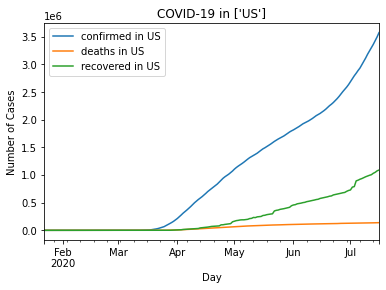

In [17]:
#Still testing and experimenting
def compare_countries(list_countries):    
    for country in list_countries:
        for data in dataset:
            country_data = data[0]
            country_data = country_data.loc[country]
            country_data = country_data.plot(label=data[1] + " in " + str(country))

    country_data.set_ylabel("Number of Cases")
    country_data.set_xlabel("Day")
    country_data.set_title("COVID-19 in " + str(list(list_countries)))
    country_data.legend()
    
    #plt.savefig(str(list_countries) + ".png")
    
compare_countries(['US'])

In [18]:
update_all_cases_country_individual()

<Figure size 432x288 with 0 Axes>

In [19]:
update_all_cases_country()

<Figure size 432x288 with 0 Axes>

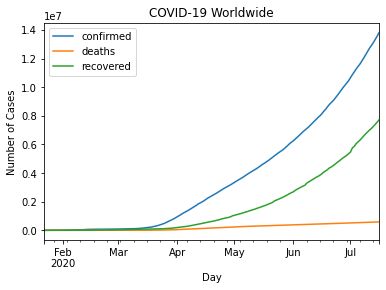

In [20]:
worldwide_cases()

In [21]:
update_all_cases_country_active()

<Figure size 432x288 with 0 Axes>

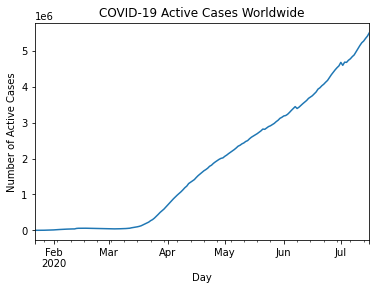

In [22]:
worldwide_active()

## Data with US Data
Functions that chart US data, from the NYTimes database.

In [23]:
def cases_by_state(state):
    df = COVID19_US_states.loc[COVID19_US_states['state'] == state].drop(['fips'], axis=1)
    pd.to_datetime(df['date'])
    
    df = df.set_index(df['date']).drop(['date'], axis=1)
    df = df.sort_values(by=['date'])

    #return df
    return df.plot()

In [24]:
def update_states():
    for state in states:
        us_cases = cases_by_state(state)
        
        us_cases.set_ylabel("Cases")
        us_cases.set_xlabel("Day")
        us_cases.set_title("COVID-19 Cases in " + str(state))
        
        plt.savefig("cases_us_states/" + str(state) + ".png")
        plt.clf

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

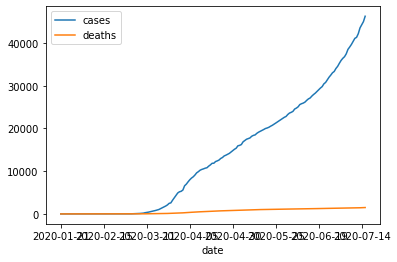

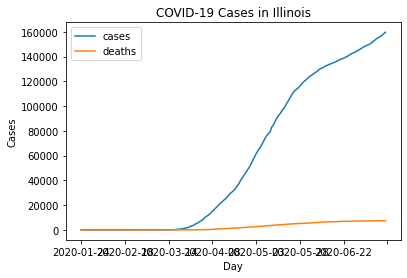

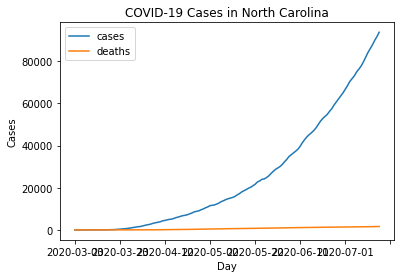

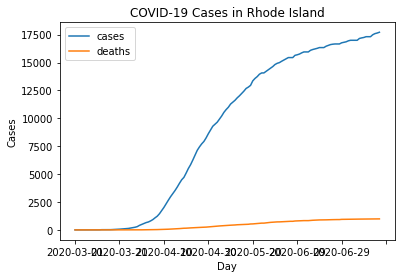

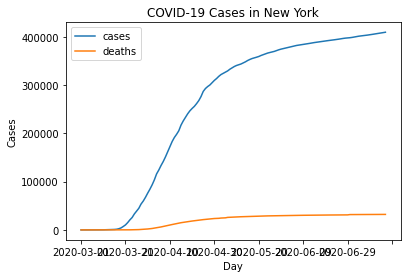

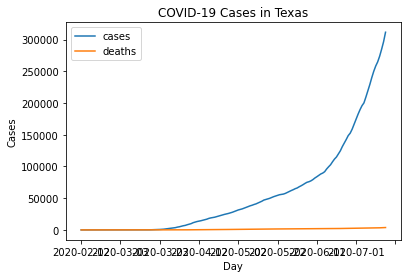

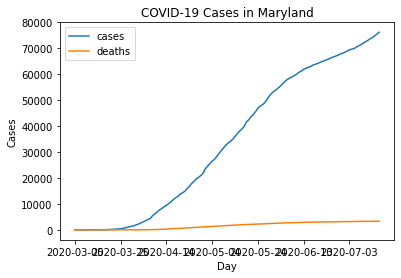

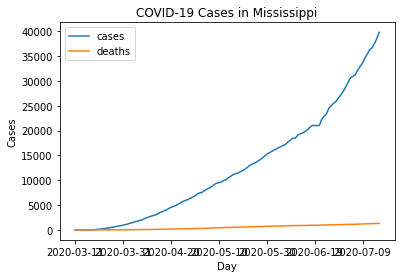

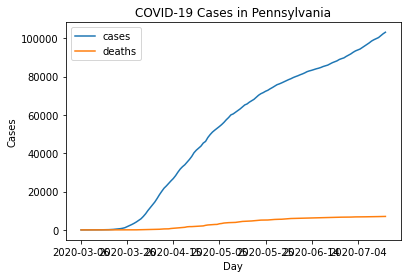

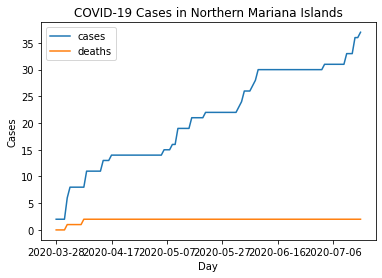

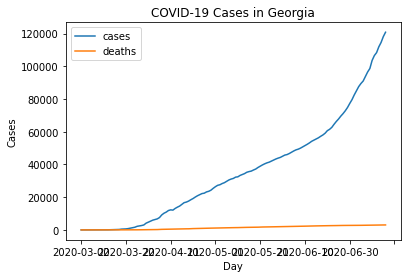

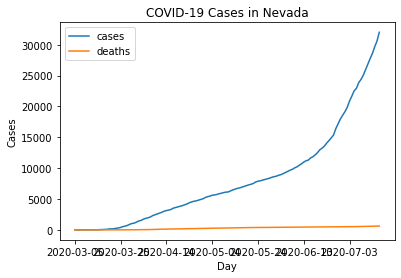

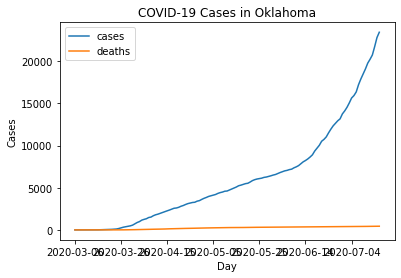

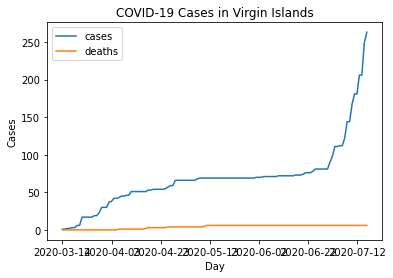

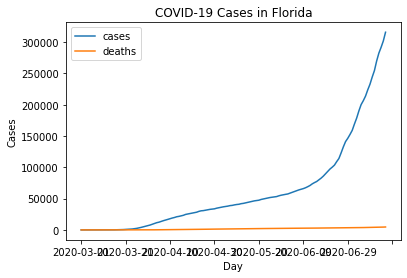

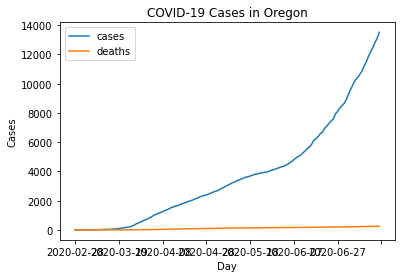

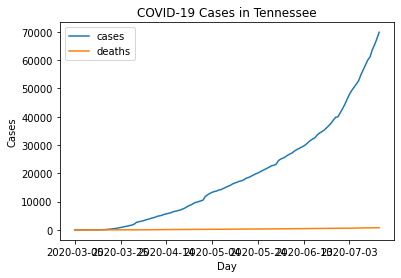

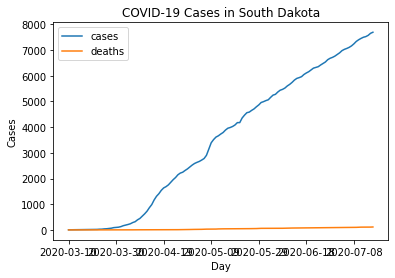

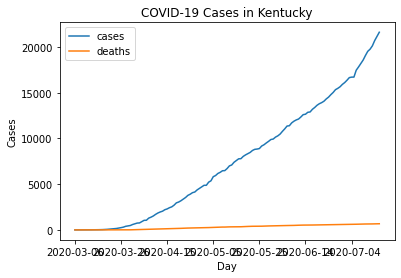

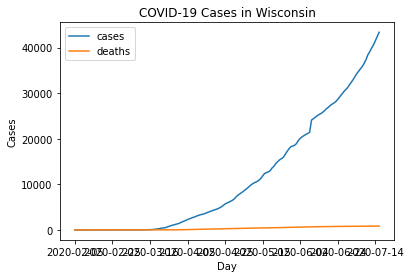

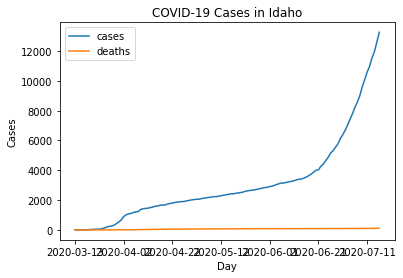

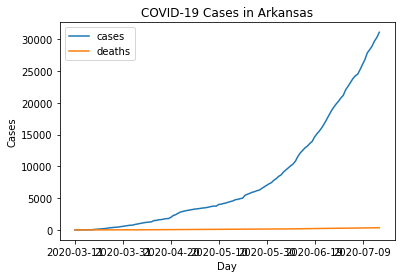

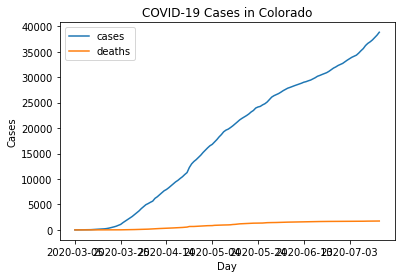

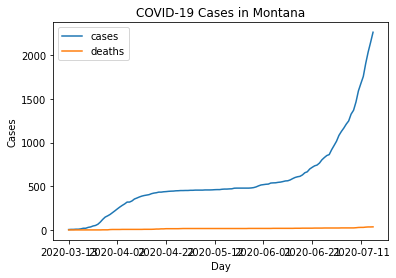

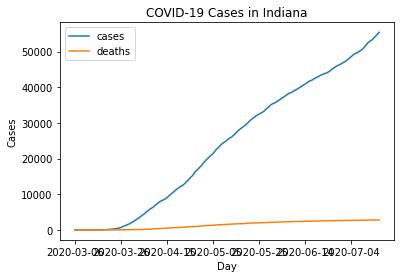

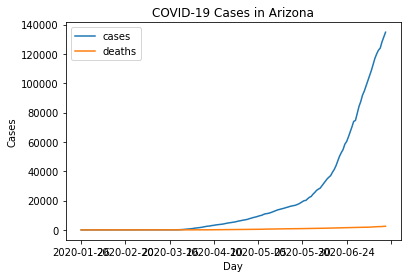

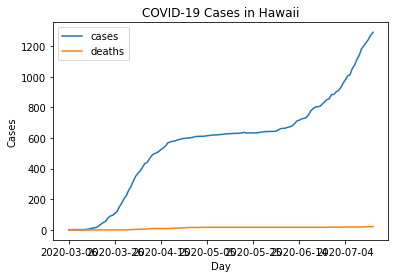

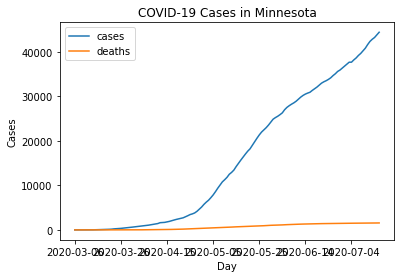

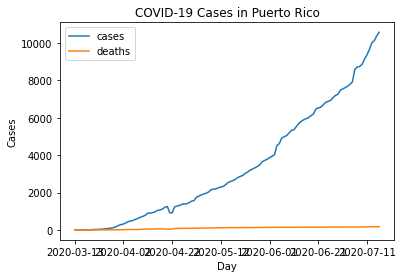

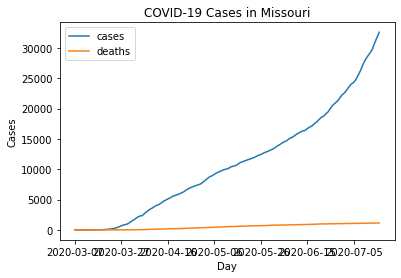

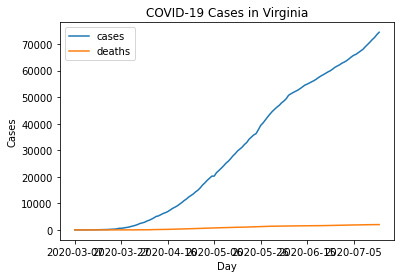

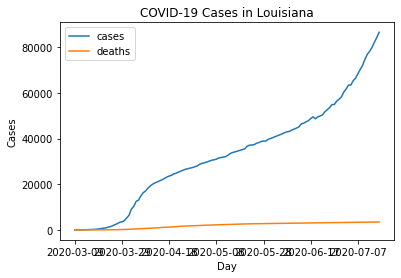

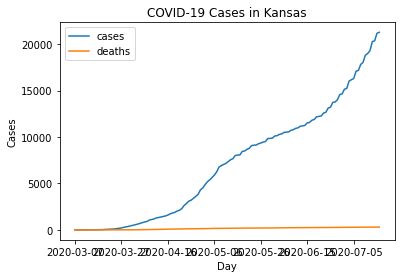

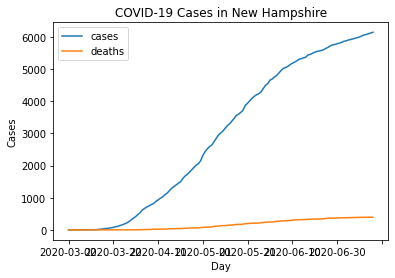

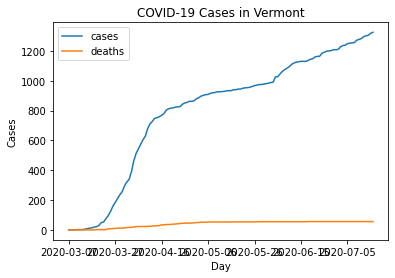

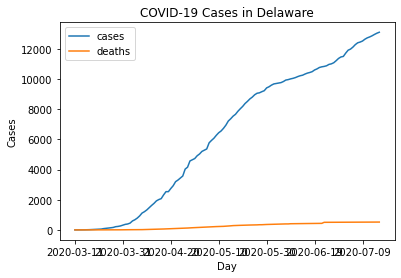

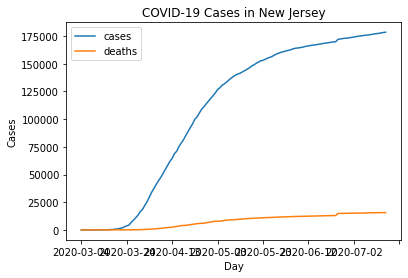

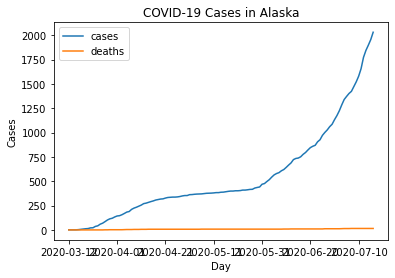

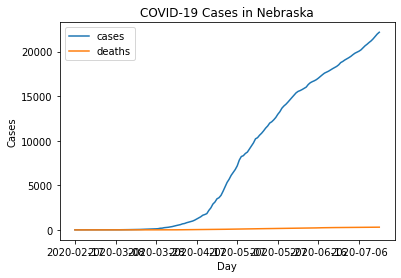

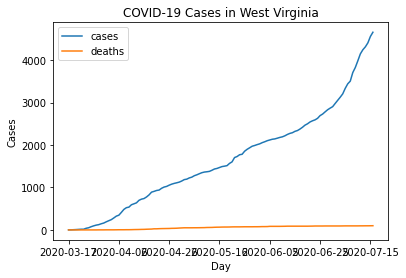

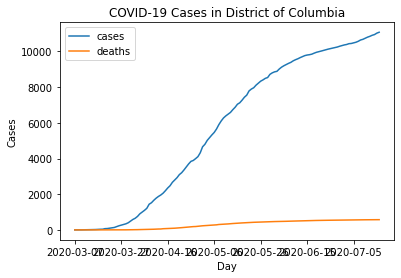

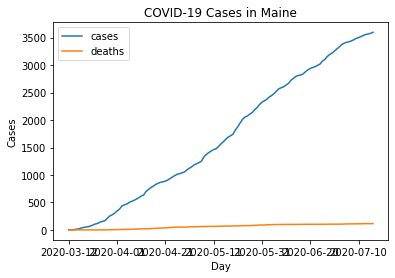

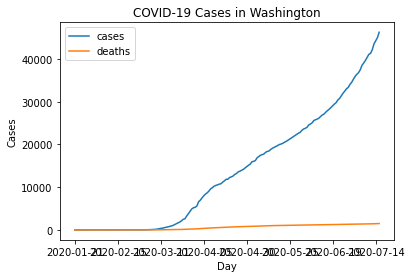

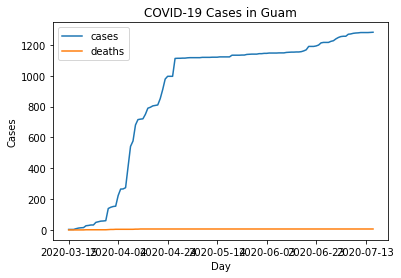

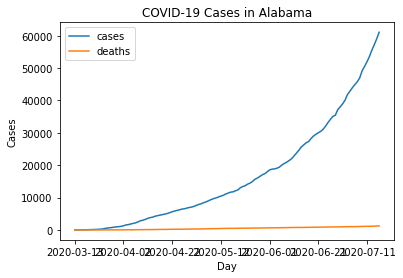

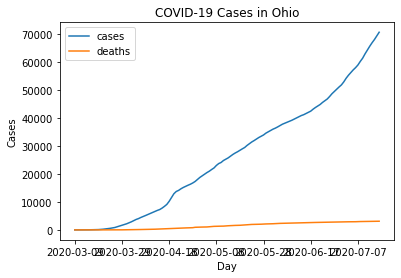

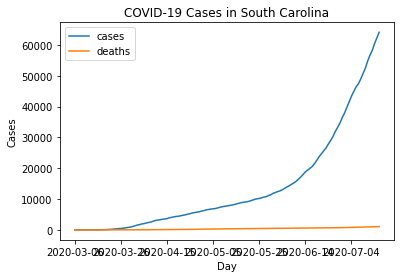

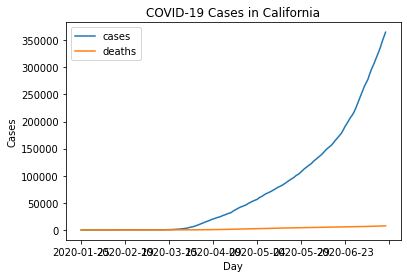

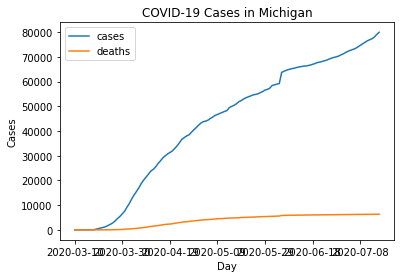

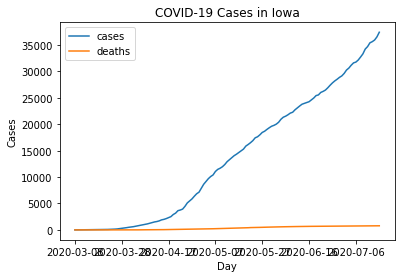

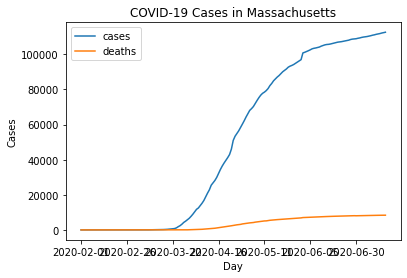

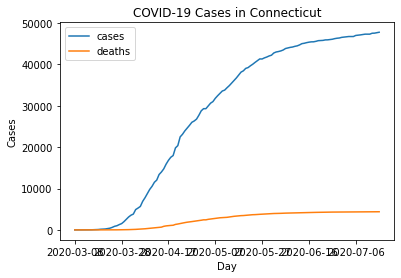

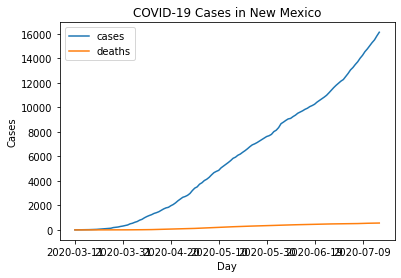

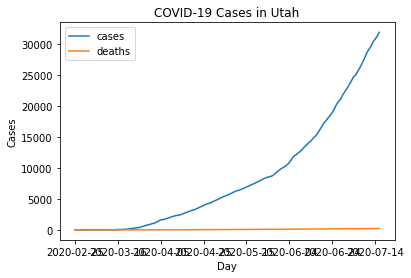

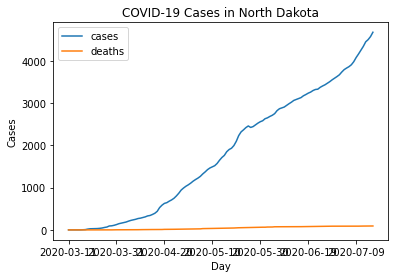

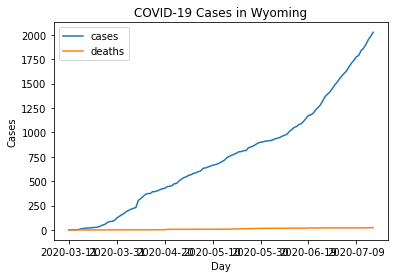

In [25]:
cases_by_state('Washington')
update_states()

# Visualizations with Global Data

In [26]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [27]:
COVID19_geo_confirmed = dataset[0][0]
COVID19_geo_deaths = dataset[1][0]
COVID19_geo_recovered = dataset[2][0]

COVID19_geo_confirmed.reset_index(level=0, inplace=True)
COVID19_geo_deaths.reset_index(level=0, inplace=True)
COVID19_geo_recovered.reset_index(level=0, inplace=True)

COVID19_geo_confirmed = COVID19_geo_confirmed.rename(columns={"Country/Region" : "name"})
COVID19_geo_deaths = COVID19_geo_deaths.rename(columns={"Country/Region" : "name"})
COVID19_geo_recovered = COVID19_geo_recovered.rename(columns={"Country/Region" : "name"})

COVID19_geo_confirmed = COVID19_geo_confirmed.replace({'Taiwan*': 'Taiwan', 'Korea, South': 'South Korea', 'US' : 'United States of America'})
COVID19_geo_deaths = COVID19_geo_deaths.replace({'Taiwan*': 'Taiwan', 'Korea, South': 'South Korea', 'US' : 'United States of America'})
COVID19_geo_recovered = COVID19_geo_recovered.replace({'Taiwan*': 'Taiwan', 'Korea, South': 'South Korea', 'US' : 'United States of America'})

#Delete any islands and Antartica
world_confirmed = world.merge(COVID19_geo_confirmed, how = 'inner', on = 'name')
world_confirmed = world_confirmed[(world_confirmed.pop_est>0) & (world_confirmed.name!="Antarctica")]

world_deaths = world.merge(COVID19_geo_deaths, how = 'inner', on = 'name')
world_deaths = world_deaths[(world_deaths.pop_est>0) & (world_deaths.name!="Antarctica")]

world_recovered = world.merge(COVID19_geo_recovered, how = 'inner', on = 'name')
world_recovered = world_recovered[(world_recovered.pop_est>0) & (world_recovered.name!="Antarctica")]

In [28]:
dates = list(COVID19_geo_confirmed)
dates.remove('name')
dates.sort()

In [29]:
def geo_confirmed_corona(data):    
    for i in range(len(dates)):
        fig, ax = plt.subplots(1, 1)

        world_confirmed.plot(column=dates[i],
                   cmap='Reds',
                   ax=ax,
                   legend=True,
                   legend_kwds={'label': "Population by Country",
                                'orientation': "horizontal"})

        #Save the figure
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(20, 10)
        fig.savefig('geo/geo_confirmed_normalized/' + str(i).zfill(3) + '.png', dpi=100)
        plt.close(fig)

In [30]:
def geo_deaths_corona(data):
    for i in range(len(dates)):
        fig, ax = plt.subplots(1, 1)

        world_deaths.plot(column=dates[i],
                   cmap='Greys',
                   ax=ax,
                   legend=True,
                   legend_kwds={'label': "Population by Country",'orientation': "horizontal"})

        #Save the figure
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(20, 10)
        fig.savefig('geo/geo_deaths_normalized/' + str(i).zfill(3) + '.png', dpi=100)
        plt.close(fig)

In [31]:
def geo_recovered_corona(data):
    for i in range(len(dates)):
        fig, ax = plt.subplots(1, 1)

        world_recovered.plot(column=dates[i],
                   cmap='Greens',
                   ax=ax,
                   legend=True,
                   legend_kwds={'label': "Population by Country",'orientation': "horizontal"})

        #Save the figure
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(20, 10)
        fig.savefig('geo/geo_recovered_normalized/' + str(i).zfill(3) + '.png', dpi=100)
        plt.close(fig)

In [32]:
geo_confirmed_corona(COVID19_geo_confirmed)
geo_deaths_corona(COVID19_geo_deaths)
geo_recovered_corona(COVID19_geo_recovered)

In [33]:
#New color theme to display color gradients
Solarcorona = ['rgb(252, 222, 156)', 'rgb(250, 164, 118)', 'rgb(240, 116, 110)', 'rgb(227, 79, 111)', 'rgb(220, 57, 119)', 'rgb(185, 37, 122)', 'rgb(124, 29, 111)', '#1b0c41', '#000004']

In [34]:
#SCRAP PREVIOUS
#New dataframes
mapping = {country.name: country.alpha_3 for country in pycountry.countries}
geo_confirmed = COVID19_confirmed.rename(index={'Korea, South': 'Korea, Republic of', 'US' :'United States', 'Taiwan*' :'Taiwan, Province of China', 'Vietnam':'Viet Nam', 'Russia': 'Russian Federation', 'Iran': 'Iran, Islamic Republic of', 'Tanzania': 'Tanzania, United Republic of', 'Laos': "Lao People's Democratic Republic", 'Syria': 'Syrian Arab Republic', 'Brunei': 'Brunei Darussalam', 'Venezuela': 'Venezuela, Bolivarian Republic of', 'Bolivia':  'Bolivia, Plurinational State of', 'Moldova': 'Moldova, Republic of'}).rename(index = lambda name: mapping.get(name))
geo_deaths = COVID19_deaths.rename(index={'Korea, South': 'Korea, Republic of', 'US' :'United States', 'Taiwan*' :'Taiwan, Province of China', 'Vietnam':'Viet Nam', 'Russia': 'Russian Federation', 'Iran': 'Iran, Islamic Republic of', 'Tanzania': 'Tanzania, United Republic of', 'Laos': "Lao People's Democratic Republic", 'Syria': 'Syrian Arab Republic', 'Brunei': 'Brunei Darussalam', 'Venezuela': 'Venezuela, Bolivarian Republic of', 'Bolivia':  'Bolivia, Plurinational State of', 'Moldova': 'Moldova, Republic of'}).rename(index = lambda name: mapping.get(name))
geo_recovered = COVID19_recovered.rename(index={'Korea, South': 'Korea, Republic of', 'US' :'United States', 'Taiwan*' :'Taiwan, Province of China', 'Vietnam':'Viet Nam', 'Russia': 'Russian Federation', 'Iran': 'Iran, Islamic Republic of', 'Tanzania': 'Tanzania, United Republic of', 'Laos': "Lao People's Democratic Republic", 'Syria': 'Syrian Arab Republic', 'Brunei': 'Brunei Darussalam', 'Venezuela': 'Venezuela, Bolivarian Republic of', 'Bolivia':  'Bolivia, Plurinational State of', 'Moldova': 'Moldova, Republic of'}).rename(index = lambda name: mapping.get(name))

In [35]:
#confirmed 500000
#deaths 10000
#recovered 100000

def geo_frames(df, file, case_range):
    for i in range(len(geo_confirmed.columns)):
        fig = px.choropleth(df, locations=df.index,
                            color=geo_confirmed.columns[i],
                            range_color=(0, case_range),
                            color_continuous_scale=Solarcorona,
                           )

        fig.update_layout(
            title_text = 'COVID-19 Cases Confirmed                        GitHub: briancpark',
        )

        #fig.show()
        fig.write_html("geo/" + file + "_html/" + str(i).zfill(3) + ".html")
        
#geo_frames(geo_confirmed, "geo_confirmed", 200000)

In [36]:
"""
for i in range(len(geo_confirmed.columns)):
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get("file:///Users/brianpark/Desktop/PUBLISHED%20Projects/COVID19/geo/geo_confirmed_html/" + str(i).zfill(3) + ".html")
    time.sleep(3)
    driver.save_screenshot("geo/geo_confirmed/" + str(i).zfill(3) + ".png")
    driver.close()
"""

'\nfor i in range(len(geo_confirmed.columns)):\n    driver = webdriver.Chrome(ChromeDriverManager().install())\n    driver.get("file:///Users/brianpark/Desktop/PUBLISHED%20Projects/COVID19/geo/geo_confirmed_html/" + str(i).zfill(3) + ".html")\n    time.sleep(3)\n    driver.save_screenshot("geo/geo_confirmed/" + str(i).zfill(3) + ".png")\n    driver.close()\n'

In [37]:
#len(geo_confirmed.columns)

# Visualizations with US Data
For some reason, plotly doesn't want to work when `write_image()` is called, so I used selenium instead to screenshot. Not a very convenient way, but in the end it gives high quality graphs.

In [38]:
dates = list(set(list(COVID19_US_states['date'])))
dates.sort(key = lambda date: datetime.strptime(date, '%Y-%m-%d')) 
states = list(set(list(COVID19_US_states['state'])))

In [39]:
def create_html(i, data_type, data_label, color_gradient, max_cases, date):
    df = COVID19_US_counties#pd.read_csv("databases/nytimes/us-counties.csv", dtype={"fips": str})
    df = df[df['date']==date]

    fig = px.choropleth(df, geojson=counties, locations='fips', color=data_type,
                               color_continuous_scale=color_gradient,
                               range_color=(0, max_cases),
                               scope="usa",
                               labels={data_type:data_type}
                              )
    fig.update_layout(title_text = 'USA COVID-19 ' + data_label + ' by County on ' + str(date) + "              GitHub:briancpark")
    fig.write_html("geo/geo_us_" + data_type + "_html/" + str(i).zfill(3) + ".html")

In [40]:
def update_us_cases_by_counties(max_cases):
        
    i = 0

    for date in dates:
        create_html(i, 'cases', 'Cases', "Sunsetdark", max_cases, date)       
        i = i + 1

In [41]:
def update_us_deaths_by_counties(max_cases):
    i = 0
    
    for date in dates:
        create_html(i, 'deaths', 'Deaths', "Greys", max_cases, date)
        i = i + 1

In [42]:
def convert_to_png(file, limit):
    if file == "confirmed":
        directory = "geo_us_cases"
    else:
        directory = "geo_us_deaths"
    
    for i in range(len(dates) - limit, len(dates)):
        driver = webdriver.Chrome(ChromeDriverManager().install())
        driver.get("file:///Users/brianpark/Desktop/PUBLISHED%20Projects/COVID19/geo/" + directory + "_html/" + str(i).zfill(3) + ".html")
        time.sleep(3)
        driver.save_screenshot("geo/" + directory + "/" + str(i).zfill(3) + ".png")
        driver.close()

## Compile Timelapses
Create beautiful, and yet alarming dynamic graphs that implement time with COVID-19. `ffmpeg` is used to compile the `.gif` and `.mp4` files. Please make sure you have that installed. Can be simply done in your terminal via `pip install ffmpeg`

In [43]:
def compile_timelapse():
    !rm timelapses/global_confirmed_timelapse.mp4
    !rm timelapses/global_deaths_timelapse.mp4
    !rm timelapses/global_recovered_timelapse.mp4
    
    !rm timelapses/global_confirmed_timelapse.gif
    !rm timelapses/global_deaths_timelapse.gif
    !rm timelapses/global_recovered_timelapse.gif
    
    !ffmpeg -r 15 -i geo/geo_confirmed/%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p timelapses/global_confirmed_timelapse.mp4
    !ffmpeg -r 15 -i geo/geo_deaths/%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p timelapses/global_deaths_timelapse.mp4
    !ffmpeg -r 15 -i geo/geo_recovered/%03d.png -c:v libx26|4 -r 30 -pix_fmt yuv420p timelapses/global_recovered_timelapse.mp4
        
    !ffmpeg -i timelapses/global_confirmed_timelapse.mp4 timelapses/global_confirmed_timelapse.gif
    !ffmpeg -i timelapses/global_deaths_timelapse.mp4 timelapses/global_deaths_timelapse.gif
    !ffmpeg -i timelapses/global_recovered_timelapse.mp4 timelapses/global_recovered_timelapse.gif
    
    !rm timelapses/global_confirmed_normalized_timelapse.mp4
    !rm timelapses/global_deaths_normalized_timelapse.mp4
    !rm timelapses/global_recovered_normalized_timelapse.mp4
    
    !rm timelapses/global_confirmed_normalized_timelapse.gif
    !rm timelapses/global_deaths_normalized_timelapse.gif
    !rm timelapses/global_recovered_normalized_timelapse.gif
    
    !ffmpeg -r 15 -i geo/geo_confirmed_normalized/%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p timelapses/global_confirmed_normalized_timelapse.mp4
    !ffmpeg -r 15 -i geo/geo_deaths_normalized/%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p timelapses/global_deaths_normalized_timelapse.mp4
    !ffmpeg -r 15 -i geo/geo_recovered_normalized/%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p timelapses/global_recovered_normalized_timelapse.mp4
        
    !ffmpeg -i timelapses/global_confirmed_normalized_timelapse.mp4 timelapses/global_confirmed_normalized_timelapse.gif
    !ffmpeg -i timelapses/global_deaths_normalized_timelapse.mp4 timelapses/global_deaths_normalized_timelapse.gif
    !ffmpeg -i timelapses/global_recovered_normalized_timelapse.mp4 timelapses/global_recovered_normalized_timelapse.gif
    
    !rm timelapses/us_confirmed_timelapse.mp4
    !rm timelapses/us_confirmed_timelapse.gif
    
    !rm timelapses/us_deaths_timelapse.mp4
    !rm timelapses/us_deaths_timelapse.gif
    
    !ffmpeg -r 15 -i geo/geo_us_cases/%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p timelapses/us_confirmed_timelapse.mp4    
    !ffmpeg -i timelapses/us_confirmed_timelapse.mp4 timelapses/us_confirmed_timelapse.gif
    
    !ffmpeg -r 15 -i geo/geo_us_deaths/%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p timelapses/us_deaths_timelapse.mp4
    !ffmpeg -i timelapses/us_deaths_timelapse.mp4 timelapses/us_deaths_timelapse.gif

In [44]:
update_us_cases_by_counties(1000)

In [45]:
update_us_deaths_by_counties(100)

In [46]:
convert_to_png("confirmed", 5) #len(dates)) #10

[WDM] - Current google-chrome version is 83.0.4103
[WDM] - Get LATEST driver version for 83.0.4103
[WDM] - Driver [/Users/brianpark/.wdm/drivers/chromedriver/mac64/83.0.4103.39/chromedriver] found in cache


[WDM] - Current google-chrome version is 83.0.4103
[WDM] - Get LATEST driver version for 83.0.4103
[WDM] - Driver [/Users/brianpark/.wdm/drivers/chromedriver/mac64/83.0.4103.39/chromedriver] found in cache


[WDM] - Current google-chrome version is 83.0.4103
[WDM] - Get LATEST driver version for 83.0.4103
[WDM] - Driver [/Users/brianpark/.wdm/drivers/chromedriver/mac64/83.0.4103.39/chromedriver] found in cache


[WDM] - Current google-chrome version is 83.0.4103
[WDM] - Get LATEST driver version for 83.0.4103
[WDM] - Driver [/Users/brianpark/.wdm/drivers/chromedriver/mac64/83.0.4103.39/chromedriver] found in cache


[WDM] - Current google-chrome version is 83.0.4103
[WDM] - Get LATEST driver version for 83.0.4103
[WDM] - Driver [/Users/brianpark/.wdm/drivers/chromedriver/mac64/83.0.4103.39/chromedriver] found in cache


In [47]:
convert_to_png("deaths", 5) #len(dates))

[WDM] - Current google-chrome version is 83.0.4103
[WDM] - Get LATEST driver version for 83.0.4103
[WDM] - Driver [/Users/brianpark/.wdm/drivers/chromedriver/mac64/83.0.4103.39/chromedriver] found in cache


[WDM] - Current google-chrome version is 83.0.4103
[WDM] - Get LATEST driver version for 83.0.4103
[WDM] - Driver [/Users/brianpark/.wdm/drivers/chromedriver/mac64/83.0.4103.39/chromedriver] found in cache


[WDM] - Current google-chrome version is 83.0.4103
[WDM] - Get LATEST driver version for 83.0.4103
[WDM] - Driver [/Users/brianpark/.wdm/drivers/chromedriver/mac64/83.0.4103.39/chromedriver] found in cache


[WDM] - Current google-chrome version is 83.0.4103
[WDM] - Get LATEST driver version for 83.0.4103
[WDM] - Driver [/Users/brianpark/.wdm/drivers/chromedriver/mac64/83.0.4103.39/chromedriver] found in cache


[WDM] - Current google-chrome version is 83.0.4103
[WDM] - Get LATEST driver version for 83.0.4103
[WDM] - Driver [/Users/brianpark/.wdm/drivers/chromedriver/mac64/83.0.4103.39/chromedriver] found in cache


In [48]:
compile_timelapse()

rm: timelapses/global_recovered_timelapse.mp4: No such file or directory
rm: timelapses/global_recovered_timelapse.gif: No such file or directory
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.3 (clang-1103.0.32.62)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp 

/bin/sh: 4: command not found
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.3 (clang-1103.0.32.62)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56.

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.3 (clang-1103.0.32.62)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 51.100 / 56. 51.100
  libavco

ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.3 (clang-1103.0.32.62)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 51.100 / 56. 51.100
  libavco

[swscaler @ 0x7fd500008000] No accelerated colorspace conversion found from yuv420p to bgr8.
Output #0, gif, to 'timelapses/global_deaths_normalized_timelapse.gif':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf58.45.100
    Stream #0:0(und): Video: gif, bgr8, 2000x1000 [SAR 1:1 DAR 2:1], q=2-31, 200 kb/s, 30 fps, 100 tbn, 30 tbc (default)
    Metadata:
      handler_name    : VideoHandler
      encoder         : Lavc58.91.100 gif
frame=  353 fps=132 q=-0.0 Lsize=    1148kB time=00:00:11.74 bitrate= 800.9kbits/s speed=4.38x    
video:1148kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001702%
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.3 (clang-1103.0.32.62)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= 

In [49]:
print(px.colors.sequential.Inferno)

['#000004', '#1b0c41', '#4a0c6b', '#781c6d', '#a52c60', '#cf4446', '#ed6925', '#fb9b06', '#f7d13d', '#fcffa4']


In [50]:
"""#Debugging cell
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)

plotly.io.orca.config.executable = '/path/to/orca'
plotly.io.orca.config.save()

df = pd.read_csv("databases/nytimes/us-counties.csv", dtype={"fips": str})
df = df[df['date']=="2020-05-08"]
df['cases'] = 1 / np.log10(df["cases"])

Solarcorona = ['rgb(252, 222, 156)', 'rgb(250, 164, 118)', 'rgb(240, 116, 110)', 'rgb(227, 79, 111)', 'rgb(220, 57, 119)', 'rgb(185, 37, 122)', 'rgb(124, 29, 111)', '#1b0c41', '#000004']

#Solarcorona = ['rgb(252, 222, 156)', 'rgb(250, 164, 118)', 'rgb(220, 57, 119)', 'rgb(185, 37, 122)', 'rgb(124, 29, 111)', '#1b0c41', '#000004', '#000004', '#000004', '#000004', '#000004', '#000004', '#000004', '#000004', '#000004']

fig = px.choropleth(df, geojson=counties, locations='fips', color='cases',
                           color_continuous_scale=Solarcorona,
                           range_color=(0, 100000),
                           scope="usa",
                           labels={'cases':'cases'}
                          )
fig.update_layout(#margin={"r":0,"t":0,"l":0,"b":0}),
                  title_text = 'USA COVID-19 Cases by County on ' + "05-08" + "              GitHub:briancpark",
coloraxis_colorbar=dict(
    title="Population",
    ticktext=["1M", "10M", "100M", "1B"],
))


                    
fig.show()
"""

'#Debugging cell\nwith urlopen(\'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json\') as response:\n        counties = json.load(response)\n\nplotly.io.orca.config.executable = \'/path/to/orca\'\nplotly.io.orca.config.save()\n\ndf = pd.read_csv("databases/nytimes/us-counties.csv", dtype={"fips": str})\ndf = df[df[\'date\']=="2020-05-08"]\ndf[\'cases\'] = 1 / np.log10(df["cases"])\n\nSolarcorona = [\'rgb(252, 222, 156)\', \'rgb(250, 164, 118)\', \'rgb(240, 116, 110)\', \'rgb(227, 79, 111)\', \'rgb(220, 57, 119)\', \'rgb(185, 37, 122)\', \'rgb(124, 29, 111)\', \'#1b0c41\', \'#000004\']\n\n#Solarcorona = [\'rgb(252, 222, 156)\', \'rgb(250, 164, 118)\', \'rgb(220, 57, 119)\', \'rgb(185, 37, 122)\', \'rgb(124, 29, 111)\', \'#1b0c41\', \'#000004\', \'#000004\', \'#000004\', \'#000004\', \'#000004\', \'#000004\', \'#000004\', \'#000004\', \'#000004\']\n\nfig = px.choropleth(df, geojson=counties, locations=\'fips\', color=\'cases\',\n                          

In [51]:
"""
#Debugging cell
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)

plotly.io.orca.config.executable = '/path/to/orca'
plotly.io.orca.config.save()

df = pd.read_csv("databases/nytimes/us-counties.csv", dtype={"fips": str})
df = df[df['date']=="2020-05-08"]

Solarcorona = ['rgb(252, 222, 156)', 'rgb(250, 164, 118)', 'rgb(240, 116, 110)', 'rgb(227, 79, 111)', 'rgb(220, 57, 119)', 'rgb(185, 37, 122)', 'rgb(124, 29, 111)', '#1b0c41', '#000004']

#Solarcorona = ['rgb(252, 222, 156)', 'rgb(250, 164, 118)', 'rgb(220, 57, 119)', 'rgb(185, 37, 122)', 'rgb(124, 29, 111)', '#1b0c41', '#000004', '#000004', '#000004', '#000004', '#000004', '#000004', '#000004', '#000004', '#000004']

fig = px.choropleth(df, geojson=counties, locations='fips', color='deaths',
                           color_continuous_scale="Greys",
                           range_color=(0, 100),
                           scope="usa",
                           labels={'deaths':'deaths'},
                          )
fig.update_layout(#margin={"r":0,"t":0,"l":0,"b":0}),
                  title_text = 'USA COVID-19 Deaths by County on ' + "05-08" + "              GitHub:briancpark")
fig.show()
"""

'\n#Debugging cell\nwith urlopen(\'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json\') as response:\n        counties = json.load(response)\n\nplotly.io.orca.config.executable = \'/path/to/orca\'\nplotly.io.orca.config.save()\n\ndf = pd.read_csv("databases/nytimes/us-counties.csv", dtype={"fips": str})\ndf = df[df[\'date\']=="2020-05-08"]\n\nSolarcorona = [\'rgb(252, 222, 156)\', \'rgb(250, 164, 118)\', \'rgb(240, 116, 110)\', \'rgb(227, 79, 111)\', \'rgb(220, 57, 119)\', \'rgb(185, 37, 122)\', \'rgb(124, 29, 111)\', \'#1b0c41\', \'#000004\']\n\n#Solarcorona = [\'rgb(252, 222, 156)\', \'rgb(250, 164, 118)\', \'rgb(220, 57, 119)\', \'rgb(185, 37, 122)\', \'rgb(124, 29, 111)\', \'#1b0c41\', \'#000004\', \'#000004\', \'#000004\', \'#000004\', \'#000004\', \'#000004\', \'#000004\', \'#000004\', \'#000004\']\n\nfig = px.choropleth(df, geojson=counties, locations=\'fips\', color=\'deaths\',\n                           color_continuous_scale="Greys",\n      

In [52]:
"""
#Debugging this cell

df = pd.read_csv("databases/nytimes/us-counties.csv", dtype={"fips": str})
df['fips'] = pd.to_numeric(df['fips'], errors='coerce')
df = df.dropna(subset=['fips'])
df['fips'] = df['fips'].astype(int)
df = df[df['date']=="2020-05-05"]


colorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
    "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
    "#08519c", "#0b4083", "#08306b"]
    
endpts = list(np.linspace(1, 1000, len(colorscale) - 1))
fips = df['fips'].tolist()
values = df['cases'].tolist()


fig = ff.create_choropleth(
    fips=fips, values=values, scope=['usa'],
    binning_endpoints=endpts, colorscale=colorscale,
    show_state_data=False,
    show_hover=True,
    asp = 2.9,
    title_text = 'COVID-19 in USA',
    legend_title = 'Cases'
)
fig.layout.template = None
fig.show()


#plotly.io.write_image(fig, "image.png", format=None, scale=None, width=None, height=None)
"""

'\n#Debugging this cell\n\ndf = pd.read_csv("databases/nytimes/us-counties.csv", dtype={"fips": str})\ndf[\'fips\'] = pd.to_numeric(df[\'fips\'], errors=\'coerce\')\ndf = df.dropna(subset=[\'fips\'])\ndf[\'fips\'] = df[\'fips\'].astype(int)\ndf = df[df[\'date\']=="2020-05-05"]\n\n\ncolorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",\n    "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",\n    "#08519c", "#0b4083", "#08306b"]\n    \nendpts = list(np.linspace(1, 1000, len(colorscale) - 1))\nfips = df[\'fips\'].tolist()\nvalues = df[\'cases\'].tolist()\n\n\nfig = ff.create_choropleth(\n    fips=fips, values=values, scope=[\'usa\'],\n    binning_endpoints=endpts, colorscale=colorscale,\n    show_state_data=False,\n    show_hover=True,\n    asp = 2.9,\n    title_text = \'COVID-19 in USA\',\n    legend_title = \'Cases\'\n)\nfig.layout.template = None\nfig.show()\n\n\n#plotly.io.write_image(fig, "image.png", format=None, scale=N

# Machine Learning Methods
A start. Goal is to predict coronavirus cases before a lockdown has initiated, and then compare it to real data. 

Let's start with exponential curve fitting with scipy!

In [53]:
df = COVID19_US_states.loc[COVID19_US_states['state'] == 'New York'].drop(['fips'], axis=1)
pd.to_datetime(df['date'])

df = df.set_index(df['date']).drop(['date'], axis=1)
df = df.sort_values(by=['date'])

#df.plot()

#ates_test = 
nydates = df.index.to_list()[:22]
lockdown_dates = df.index.to_list()[22:]

df.head(22)

,state,cases,deaths
date,,,
2020-03-01,New York,1,0
2020-03-02,New York,1,0
2020-03-03,New York,2,0
2020-03-04,New York,11,0
2020-03-05,New York,22,0
2020-03-06,New York,44,0
2020-03-07,New York,89,0
2020-03-08,New York,106,0
2020-03-09,New York,142,0


In [54]:
from scipy.optimize import curve_fit
x = np.array(range(len(nydates)))
y = np.array(df['cases'].tolist()[:22])

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(func, x, y, p0=(1, 1e-6, 1))
popt

ModuleNotFoundError: No module named 'scipy'

In [ ]:
xx = np.array(range(len(nydates) + len(lockdown_dates)))
yy = func(xx, *popt)

In [ ]:
#plt.plot(x, y, 'ko')
#plt.plot(xx, yy)
plt.plot(df.index.to_list(), df['cases'].to_list())

# Drafts and Debugging For More Visualizations!

In [ ]:
import plotly.express as px

df = px.data.election()
geojson = px.data.election_geojson()

#print(df["district"][2])
#print(geojson["features"][0]["properties"])
df = COVID19_US_counties[COVID19_US_counties['state'] == 'Alabama']
df = df[df['date'] == '2020-04-01']
df

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
df = df

import plotly.express as px

fig = px.choropleth(df, geojson=counties, locations='fips', color='cases',
                           color_continuous_scale="Viridis",
                           range_color=(0, 10000),
                           scope="usa",
                           labels={'cases':'cases'}
                          )
fig.show()

In [ ]:
counties

In [ ]:
def retrieve_state_json(state):
    custom = counties.copy()

    for county in custom["features"]:
        if county['properties']["STATE"] != "01":
            custom["features"].remove(county)

In [ ]:
custom = counties.copy()

for county in custom["features"]:
    if county['properties']["STATE"] != "01":
        custom["features"].remove(county)

In [ ]:
custom

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
df = df

import plotly.express as px

fig = px.choropleth(df, geojson=custom, locations='fips', color='cases',
                           color_continuous_scale="Viridis",
                           range_color=(0, 10000),
                           scope="usa",
                           labels={'cases':'cases'}
                          )
fig.update_geos(fitbounds="locations")
fig.show()

In [ ]:
import plotly.express as px

df = df
geojson = custom

fig = px.choropleth(df, geojson=custom, color="cases",
                    locations="county", featureidkey="01001",
                    projection="mercator"
                   )
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
custom

In [ ]:
custom['features'][0]

# BREAK

In [ ]:
#New dataframes
mapping = {country.name: country.alpha_3 for country in pycountry.countries}
geo_confirmed = COVID19_confirmed.rename(index={'Korea, South': 'Korea, Republic of', 'US' :'United States', 'Taiwan*' :'Taiwan, Province of China', 'Vietnam':'Viet Nam', 'Russia': 'Russian Federation', 'Iran': 'Iran, Islamic Republic of', 'Tanzania': 'Tanzania, United Republic of', 'Laos': "Lao People's Democratic Republic", 'Syria': 'Syrian Arab Republic', 'Brunei': 'Brunei Darussalam', 'Venezuela': 'Venezuela, Bolivarian Republic of', 'Bolivia':  'Bolivia, Plurinational State of', 'Moldova': 'Moldova, Republic of'}).rename(index = lambda name: mapping.get(name))
geo_deaths = COVID19_deaths.rename(index={'Korea, South': 'Korea, Republic of', 'US' :'United States', 'Taiwan*' :'Taiwan, Province of China', 'Vietnam':'Viet Nam', 'Russia': 'Russian Federation', 'Iran': 'Iran, Islamic Republic of', 'Tanzania': 'Tanzania, United Republic of', 'Laos': "Lao People's Democratic Republic", 'Syria': 'Syrian Arab Republic', 'Brunei': 'Brunei Darussalam', 'Venezuela': 'Venezuela, Bolivarian Republic of', 'Bolivia':  'Bolivia, Plurinational State of', 'Moldova': 'Moldova, Republic of'}).rename(index = lambda name: mapping.get(name))
geo_recovered = COVID19_recovered.rename(index={'Korea, South': 'Korea, Republic of', 'US' :'United States', 'Taiwan*' :'Taiwan, Province of China', 'Vietnam':'Viet Nam', 'Russia': 'Russian Federation', 'Iran': 'Iran, Islamic Republic of', 'Tanzania': 'Tanzania, United Republic of', 'Laos': "Lao People's Democratic Republic", 'Syria': 'Syrian Arab Republic', 'Brunei': 'Brunei Darussalam', 'Venezuela': 'Venezuela, Bolivarian Republic of', 'Bolivia':  'Bolivia, Plurinational State of', 'Moldova': 'Moldova, Republic of'}).rename(index = lambda name: mapping.get(name))

In [ ]:
df = geo_deaths
fig = px.choropleth(df, locations=df.index,
                    color="2020-02-10", # lifeExp is a column of gapminder
                    range_color=(0, 10000),
                    color_continuous_scale=Solarcorona,
                   )

fig.update_layout(
    title_text = 'COVID-19 Cases Confirmed                        GitHub: briancpark',
)

fig.show()
